# AM10 - Spring 2020
# LECTURE-11
## Module: Advanced

### Learning objectives:
Curve fiting, data noise, optimization of fit.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D  

### 1. FITTING OF DATA
### Load the data


(20,)


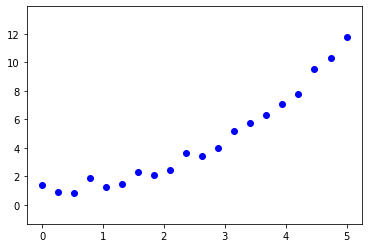

In [3]:
# Read and visualize the data (x,y)

xdat=np.loadtxt('AM10_L11_input_x.txt')
fdat=np.loadtxt('AM10_L11_input_y.txt')

check = np.shape(xdat)==np.shape(fdat)
Nd=np.shape(xdat)
if check:
    print(Nd)
    ymaxplot=np.max(fdat)
    yminplot=np.min(fdat)
    yrange=ymaxplot-yminplot
    plt.plot(xdat,fdat,'bo')
    plt.ylim(yminplot-0.2*yrange,ymaxplot+0.2*yrange)
    plt.show()



### Fit the data with a straight line

The simplest choice for a curve passing through data, assuming we don't know 
anything about the origin of the data, is a straight line
(sometimes referred to as "linear regression"). 

Let's try a straight line fit for the entire range:
$$f_{\rm fit}(x) = s x + c$$

Need to determine the parameters $s$ ("slope"), and $c$ ("constant offset") to make the fitted curve as close to the data as possible. Need to define what "close" means.  Introduce root mean square error (RMSE):

$$ {\rm RMSE} = \left [ \frac{1}{N} \sum_{n=1}^N \left [ f_{\rm fit}(x_n) - f_{\rm dat}(x_n) \right ]^2 \right ]^{1/2}
= \left [\frac{1}{N} \sum_{n=1}^N \left [ s x_n + c  - f_{\rm dat}(x_n) \right ]^2 \right ]^{1/2}
$$ 
where $f_{\rm dat}(x_n)$ are the observed values of the function (data), which include noise, at every value of the variable $x_n$ where the measurement (date point) is taken.

There are elaborate methods for trying to find the values of $s$ and $c$ (or more generally the parameters to more complicated fitting functions) to minimize the RMSE; the whole field of Statistics deals with this important issue. Here we will only try the most crude method, then we'll use a Python library that does the job for us.

## 2. Plots of functions with 2 variables

When a function depends on more than one variable, it is useful to try to "visualize" its behavior.  This gets complicates as the number of variables increases and can quickly become unmanageable. 

For the case of two variables, a convenient way to visualize the behavior of the function is by fixing its value and then finding all the values of the two variables that lead to this particular value of the function.  This produces "contours" of the function, much like the constant-height contours in a geography map.

To illustrate these concepts we will play with the gaussian function:
$$ g(x) = \frac{1}{\sqrt{2\pi} \sigma} e^{-(x-x_0)^2/2\sigma^2}$$
which in 2D looks like a "hump", or a "well" if we multiply it by a negative constant.

In 2d:
$$ g(x,y) = A \frac{1}{\sqrt{2\pi} \sigma_x} e^{-(x-x_0)^2/2\sigma_x^2} 
\frac{1}{\sqrt{2\pi} \sigma_y} e^{-(y-y_0)^2/2\sigma_y^2}
$$

In [5]:
# First, define the gaussian, which represents a bump
# the center is at x0, the width is s
# and to make it normalized (its integral is 1), multiply
# by the factor given above
def gauss1D(x,x0,s):
    g = (1.0/(np.sqrt(2.0*np.pi)*s))*np.exp(-(x-x0)**2/(2.0*s**2))
    return g


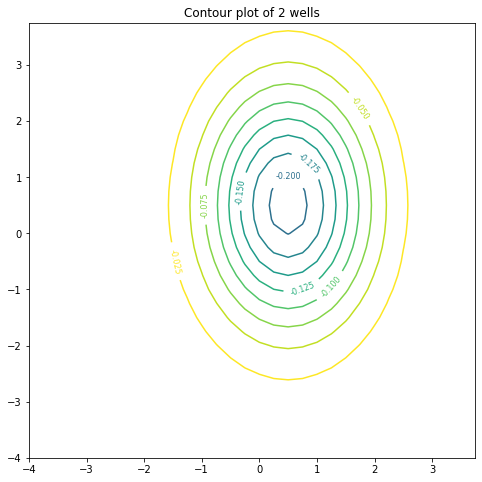

In [13]:
#
# Example: a gaussian in 2D - a "hump" or "well"
# first, define the gaussian centered at [x0,y0], with width [sx,sy] in the two dimensions
# and overall strength A.
#
def gauss2D(x,y,x0,y0,sx,sy,A):
    return A*gauss1D(x,x0,sx)*gauss1D(y,y0,sy)
#
# define a grid on the (x,y) plane, where the values of the function f(x,y) will be evaluated
#
xmin=-4.0
xmax=4.0
dx=0.25
x = np.arange(xmin, xmax, dx)

ymin=-4.0
ymax=4.0
dy=0.25
y = np.arange(ymin, ymax, dy)

X, Y = np.meshgrid(x, y)

x0=0.5
y0=0.5
sx=1.0
sy=1.5
A=-2.0

Z = gauss2D(X,Y,x0,y0,sx,sy,A)

fig, ax = plt.subplots(figsize=(8,8))

ax.set_title('Contour plot of 2 wells')
levels=np.arange(-0.3,0.0,0.025)
CS = ax.contour(X,Y,Z, levels)
ax.clabel(CS, inline=1, fontsize=8)
plt.show()

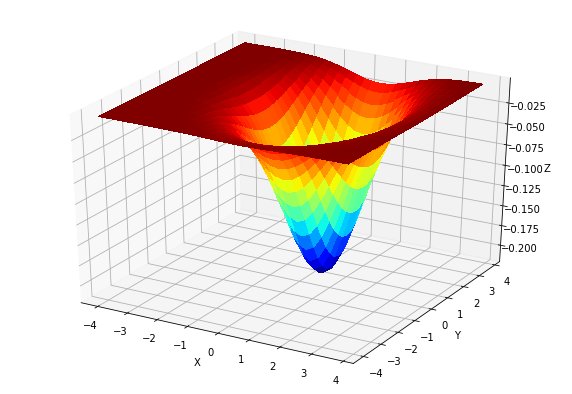

In [14]:
Nx=np.size(x)
Ny=np.size(y)
zmax=np.max(Z)
zmin=np.min(Z)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.jet, linewidth=0,
    antialiased=False)
ax.set_zlim(zmin*1.02,zmax*1.02)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

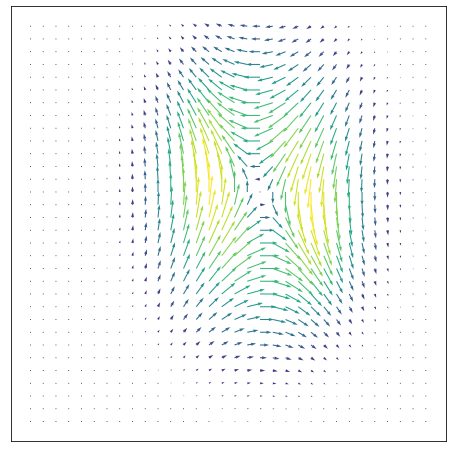

In [15]:
# The Gradient function
# Gradient descent

dx, dy = np.gradient(-Z)

fig, ax = plt.subplots(figsize=(8,8))

fn = 0
fa = 1
color = np.sqrt(((dx-fn)/fa)**2 + ((dy-fn)/fa)**2)

ax.quiver(X,Y,dx,dy,color)

ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.set_aspect('equal')

plt.show()


### 3. Make a fit by using the 2D space of (c,s)

We assume a stright line fits the data, with slope $s$ and constant offset $c$:
$$f_{\rm fit} = s x + c$$
A simple way to estimate the values of $s$ and $c$ is to use only the first and last data points:
$$ f_{0} = s x_0 + c, \; \; f_N = s x_N + c $$
Substracting the two equations:
$$ s x_N - s x_0 = f_N - f_0 \Rightarrow s = \frac{f_N-f_0}{x_N-x_0}$$
With this value of $s$, substitute in one of the equations to get:
$$f_0 = \frac{f_N-f_0}{x_N-x_0} x_0 + c \Rightarrow c = f_0 - 
\frac{f_N-f_0}{x_N-x_0} x_0$$

In [16]:
# Make a crude guess of the parameters in the linear fit 
# by fitting exactly the two end points,
# then vary their values around these guesses to get a better fit.

xini=xdat[0]
xfin=xdat[-1]
print(xini,xfin)
yini=fdat[0]
yfin=fdat[-1]
print(yini,yfin)

# fill in the correct expressions for "sguess" and "cguess"
sguess= (yfin-yini)/(xfin-xini)
cguess= yini-sguess*xini
fguess=sguess*xdat+cguess

ovrNd=(1.0/np.sqrt(Nd))
rmse=ovrNd*np.sqrt(np.sum((fguess-fdat)**2))
print(rmse)

0.0 5.0
1.38333 11.75188
[2.33318197]


In [18]:
# scan the values of s and c around the guessed values to create 
# a 2D plot of the RMSE for possible fits

smin=sguess*(1-0.5)
smax=sguess*(1+0.5)
Ns=40
s = np.linspace(smin,smax,Ns)

cmin=cguess*(1-10.0)
cmax=cguess*(1+10.0)
Nc=40
c = np.linspace(cmin,cmax,Nc)

X, Y =np.meshgrid(s,c)
rmsetry = np.zeros([Nc,Ns])

for ns in range(Ns):
    for nc in range(Nc):
        ftry=s[ns]*xdat+c[nc]
        rmsetry[nc,ns] = ovrNd*np.sqrt(np.sum((ftry-fdat)**2))

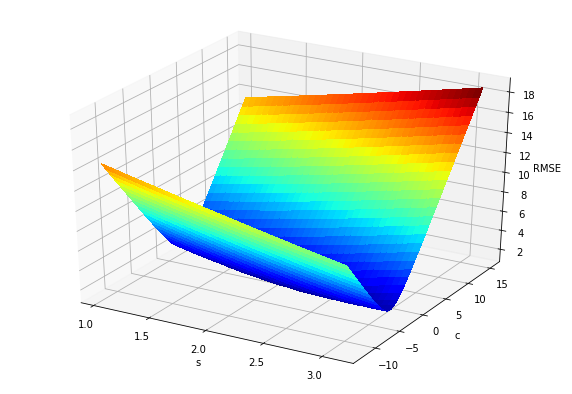

In [19]:
rmsmax=np.max(rmsetry)
rmsmin=np.min(rmsetry)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, rmsetry, rstride=1, cstride=1, cmap=cm.jet, linewidth=0,
    antialiased=False)
ax.set_zlim(rmsmin*1.02,rmsmax*1.02)

ax.set_xlabel('s')
ax.set_ylabel('c')
ax.set_zlabel('RMSE')
plt.show()

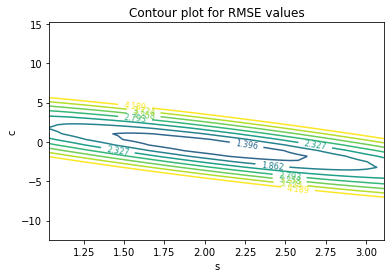

In [28]:
rmsemax=np.max(rmsetry)
conlev=.25*rmsemax/10.0

fig, ax = plt.subplots()

ax.set_title('Contour plot for RMSE values')
levels=np.arange(0,0.25*rmsemax,conlev)
CS = ax.contour(X,Y,rmsetry, levels)

ax.clabel(CS, inline=1, fontsize=8)
plt.xlabel('s')
plt.ylabel('c')
plt.show()

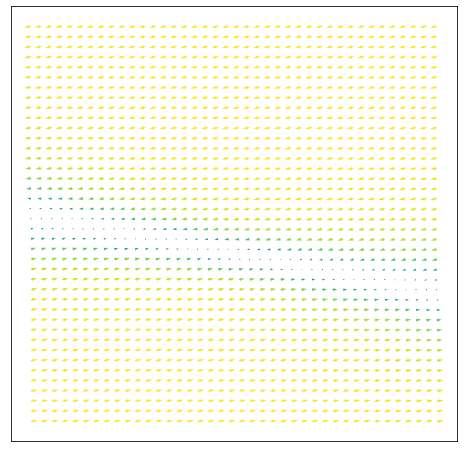

In [29]:
dx, dy = np.gradient(-rmsetry)

fig, ax = plt.subplots(figsize=(8,8))

fn = 0
fa = 1
color = np.sqrt(((dx-fn)/fa)**2 + ((dy-fn)/fa)**2)

ax.quiver(X,Y,dx,dy,color)

ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

plt.show()


### Using graphics to find the optimal solution:

By examining the contour plot above in the [s,c] space, we can guess the optimal values [sopt, copt], namely the ones that minimize the RMSE of the linear fit. Our best guess for these values, and the resulting RMSE and fit to the data are given below.

[1.03253212]


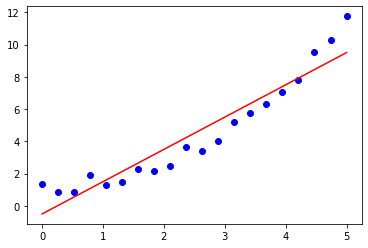

In [24]:
# The values sopt and copt are obtained by eye-balling the plot above, 
# seeing where the minimum occurs (approximately)

sopt=2.0
copt=-0.5
fopt=sopt*xdat+copt
rmseopt=ovrNd*np.sqrt(np.sum((fopt-fdat)**2))

print(rmseopt)

plt.plot(xdat,fdat,'bo')
plt.plot(xdat,fopt,'r')
plt.show()


### A "professional" fitting approach

There is of course a much more efficient way to do this, by using the Python library "curve_fit".  We'll give an example below.

[ 2.0443483  -0.63630325]
[1.03002283]


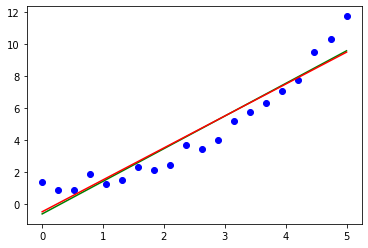

In [30]:
from scipy.optimize import curve_fit

#
# Need to define a function with a few parameters that the routine "curve_fit" will use, 
# and it will return the best values for these parameters
# We'll try a linear fit first
#
def func1(x, s, c):
    return s*x+c

popt1, pcov1 = curve_fit(func1, xdat, fdat)

print(popt1)

sopt=popt1[0]
copt=popt1[1]
ffit=func1(xdat,sopt,copt)

rmsefit=ovrNd*np.sqrt(np.sum((ffit-fdat)**2))

print(rmsefit)

plt.plot(xdat,fdat,'bo')
plt.plot(xdat,ffit,'g')
plt.plot(xdat,fopt,'r')
plt.show()

[0.97854045 1.99917731]
[0.32148333]


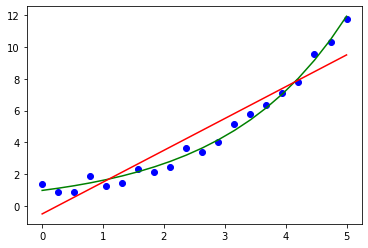

In [31]:
#
# Next we'll try an exponential fit
#
def func_guess(x, a, b):
    ' your code for the exponential here '
    f = a*np.exp(x/b)
    return f

popt2, pcov2 = curve_fit(func_guess, xdat, fdat)

print(popt2)

aopt=popt2[0]
bopt=popt2[1]
ffit=func_guess(xdat, aopt, bopt)

rmsefit=ovrNd*np.sqrt(np.sum((ffit-fdat)**2))

print(rmsefit)

plt.plot(xdat,fdat,'bo')
plt.plot(xdat,ffit,'g')
plt.plot(xdat,fopt,'r')
plt.show()